# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [ ]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [ ]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle


def draw_scooter(x, y, theta):
    x1 = x + np.sin(theta) * l / 2
    y1 = y - np.cos(theta) * l / 2
    x2 = x - np.sin(theta) * l / 2
    y2 = y + np.cos(theta) * l / 2
    xr_1, xr_2 = x1 - r * np.cos(theta), x1 + r * np.cos(theta)
    yr_1, yr_2 = y1 - r * np.sin(theta), y1 + r * np.sin(theta)
    xl_1, xl_2 = x2 - r * np.cos(theta), x2 + r * np.cos(theta)
    yl_1, yl_2 = y2 - r * np.sin(theta), y2 + r * np.sin(theta)

    plt.plot([xr_1, xr_2], [yr_1, yr_2], 'k-', linewidth=4)
    plt.plot([xl_1, xl_2], [yl_1, yl_2], 'k-', linewidth=4)
    plt.fill([xr_1, xr_2, x, xr_1], [yr_1, yr_2, y, yr_1], 'r-')
    plt.fill([xl_1, xl_2, x, xl_1], [yl_1, yl_2, y, yl_1], 'r-')

    x_m = x + 0.5 * np.cos(theta)
    y_m = y + 0.5 * np.sin(theta)
    plt.gca().add_patch(Circle((x_m, y_m), 0.03, color='green', fill=True))

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [ ]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = (16, 16 / wh_ratio)
    plt.figure(figsize=figsize)
    plt.gca().axis([xmin, xmax, ymin, ymax])
    plt.gca().set_aspect(1)
    plt.xticks(np.arange(xmin, xmax+1, 1))
    plt.yticks(np.arange(ymin, ymax+1, 1))
    plt.grid(True)

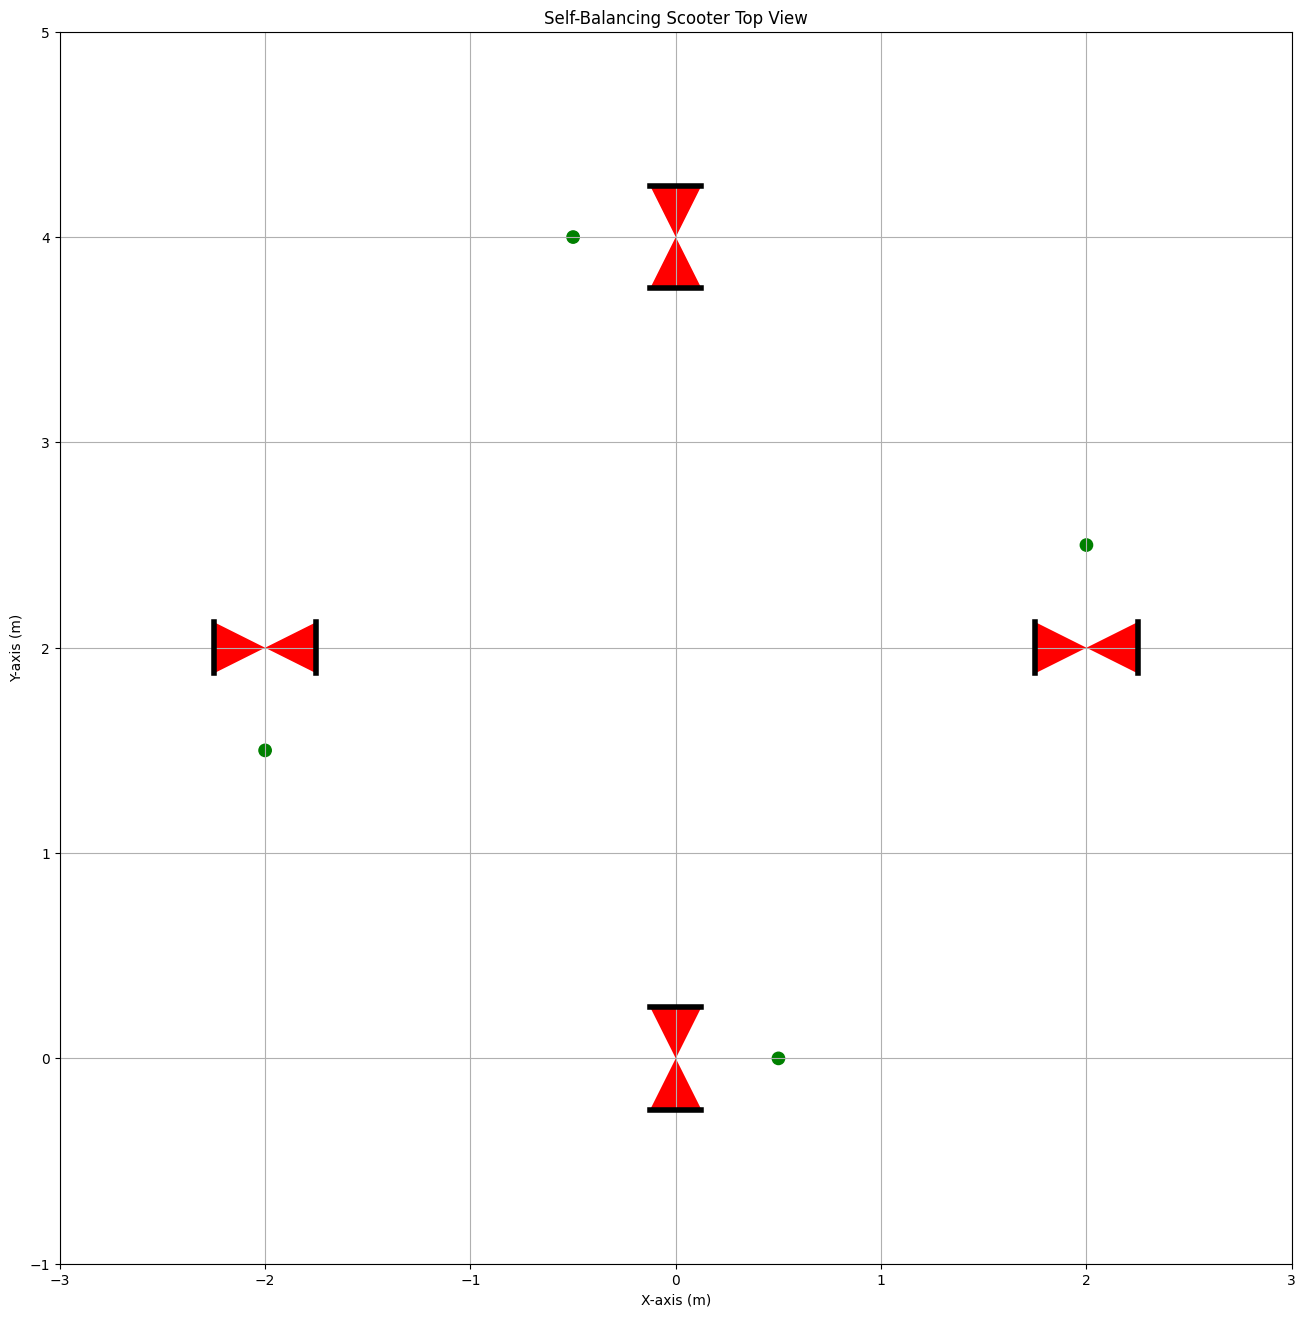

In [ ]:
draw_arena(-3, 3, -1, 5)

positions = [
    (0, 0, 0),
    (2, 2, np.pi/2),
    (0, 4, np.pi),
    (-2, 2, 3*np.pi/2)
]

for pos in positions:
    draw_scooter(*pos)

plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')
plt.title('Self-Balancing Scooter Top View')
plt.show()

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

### Kinematic Model of a Self-Balancing Scooter

We start by assuming that the scooter's movement can be described through the angular velocities of its wheels, labeled as  $\omega_l$ for the left wheel and $\omega_r$ for the right wheel. The scooter moves based on these velocities, and the differential equations linking these to the scooter's translational and rotational motion are derived as follows:

#### Differential Equations:

The key to these derivations is understanding how the wheel's motion translates into scooter movement. We establish the following relationships:

1. **Forward Velocity** \( V \):
   - The forward velocity of the scooter, taken at the midpoint of the axle, is the average of the wheel velocities, which is given by:
   $$ V = \frac{r (\omega_r + \omega_l)}{2} $$

2. **Angular Velocity** \( \dot{\theta} \):
   - The rate of change of the scooter's orientation is influenced by the difference in wheel velocities:
   $$ \dot{\theta} = \frac{r (\omega_r - \omega_l)}{L} $$

3. **Translational Velocities** \( \dot{x} \) and \( \dot{y} \):
   - The movement along the x and y axes can be described by:
   $$ \dot{x} = V \cos(\theta) = \frac{r (\omega_r + \omega_l)}{2} \cos(\theta) $$
   $$ \dot{y} = V \sin(\theta) = \frac{r (\omega_r + \omega_l)}{2} \sin(\theta) $$

#### Variable Definitions:
- \( r \): Radius of each wheel.
- \( L \): Distance between the centers of the two wheels.
- \( \theta \): Current orientation angle of the scooter.
- \( \omega_l, \omega_r \): Angular velocities of the left and right wheels, respectively.
- \( \dot{x}, \dot{y}, \dot{\theta} \): Rates of change of the scooter's position and orientation.

These equations form the basis for analyzing and controlling the motion of a self-balancing scooter.


### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

La vitesse angulaire, $\dot{\theta}$, est une fonction de $\omega_l$ et $\omega_r$ :
<br>
$$
\begin{aligned}
\dot{\theta} = \frac{r}{l} (\omega_r - \omega_l) \\
\end{aligned}
$$
<br>
Ainsi, si $\omega_l$ et $\omega_r$ sont des fonctions continûment différentiables, alors $\dot{\theta}$ l'est aussi. Par conséquent, $\theta$ est une fonction continûment différentiable. Cela implique que $\cos(\theta)$ et $\sin(\theta)$ le sont également. De plus, puisque $\dot{x}$ et $\dot{y}$ sont des fonctions de $\omega_l$, $\omega_r$ et $\theta$, il s'ensuit que $\dot{x}$ et $\dot{y}$ sont continûment différentiables.

Par conséquent, en se basant sur les théorèmes d'UNICITÉ, de CONTINUITÉ et d'EXISTENCE, nous pouvons conclure que le système est bien posé.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

Si $\omega_l$ et $\omega_r$ sont des constantes, les équations données décrivent un système dont les solutions restent finies pour $t < \infty$. Ainsi, la solution maximale associée à n'importe quel état initial est globale.

Cependant, si $\omega_l$ et $\omega_r$ deviennent des fonctions arbitraires continûment différentiables de $(x, y, \theta)$, le système devient dépendant des variables $x$, $y$ et $\theta$. Dans ce cas, les variations de ces variables au fil du temps peuvent tendre vers l'infini avec certaines valeurs initiales.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [ ]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [ ]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = (r/2) * (omega_r + omega_l)*cos(theta)
    dy = (r/2) * (omega_r + omega_l)*sin(theta)
    dtheta = (r/l) * (omega_r - omega_l)
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [ ]:
 Simulation = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

Text(0.5, 0, 'time')

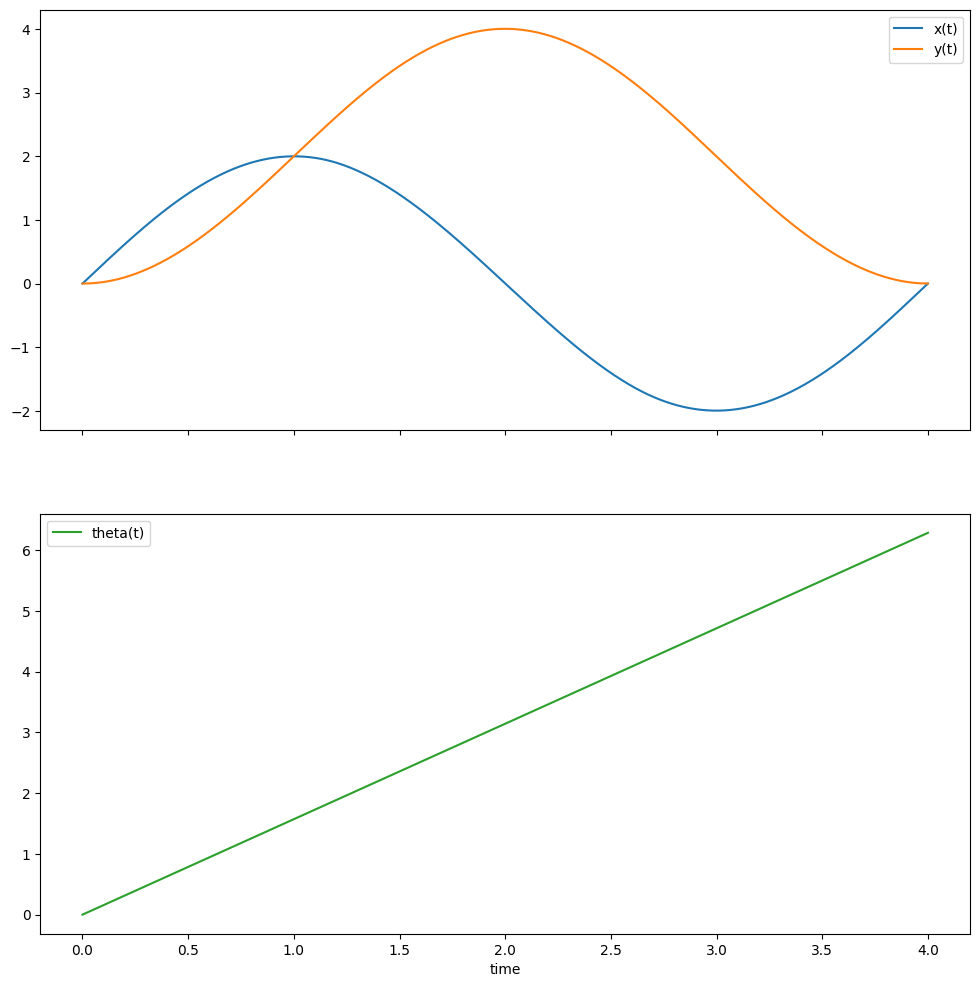

In [ ]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = Simulation["sol"](t)
fig=figure(figsize=(12, 12))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.plot(t, x, label="x(t)")
ax1.plot(t, y, label="y(t)")
ax1.legend()
ax2.plot(t, theta, label=r"theta(t)", color="C2")
ax2.legend()
xlabel("time")

🧩 Use the simulation results to display the robot location every 0.5 second.

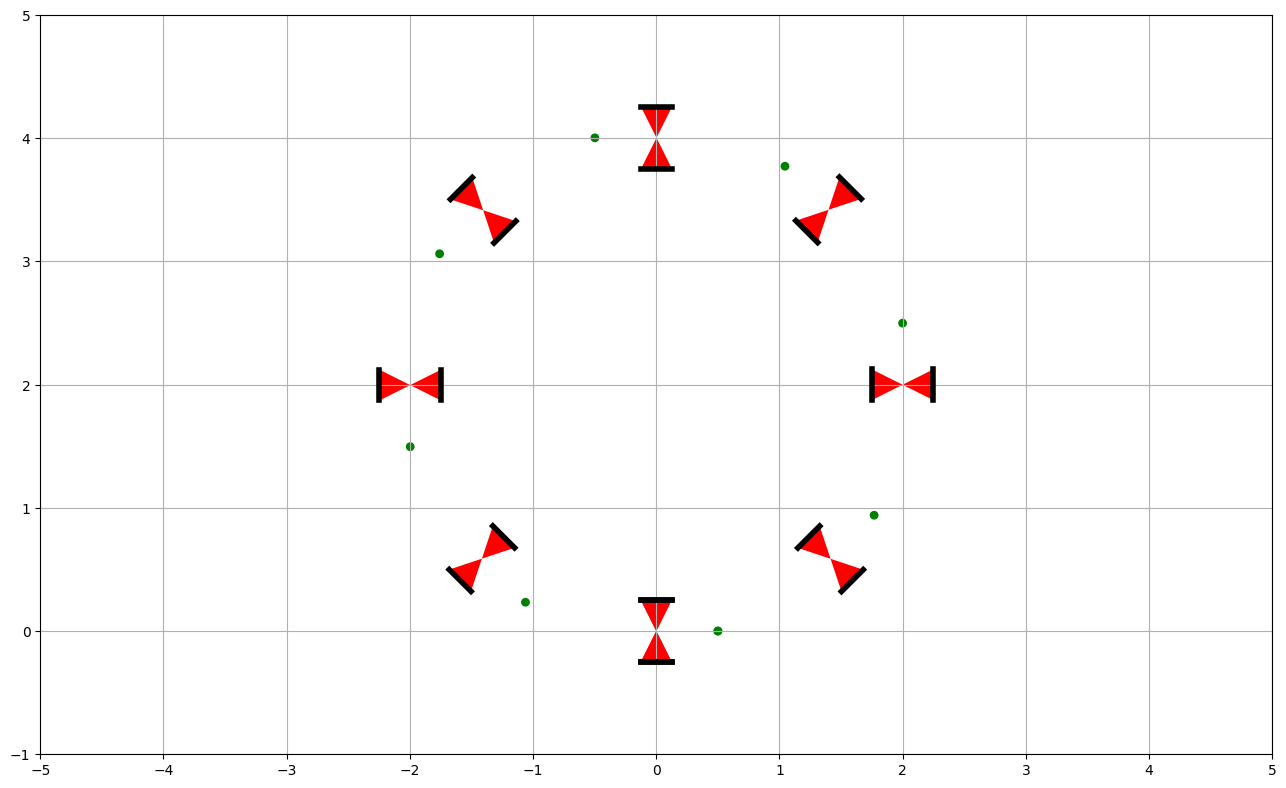

In [ ]:
draw_arena(-5, 5, -1, 5)

ts = [i * 0.5 for i in range(9)]

[draw_scooter(Simulation["sol"](t)[0],Simulation["sol"](t)[1],Simulation["sol"](t)[2]) for t in ts]

plt.show()

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

En utilisant les valeurs données pour $\omega_p$ et $\omega_r$, les équations du début se simplifient comme suit :

$$
\begin{aligned}
\dot{x} &= \pi \cos \theta \\
\dot{y} &= \pi \sin \theta \\
\dot{\theta} &= \frac{\pi}{2}
\end{aligned}
$$

Cela conduit à :

$$
\begin{aligned}
\dot{\theta} &= \frac{\pi}{2} \implies \theta = \frac{\pi}{2} t \\
\dot{x}(t) &= \pi \cos \left(\frac{\pi}{2} t\right) \\
\dot{y}(t) &= \pi \sin \left(\frac{\pi}{2} t\right)
\end{aligned}
$$

En intégrant par rapport au temps et en prenant en considération les conditions initiales, nous obtenons :

$$
\begin{aligned}
x(t) &= 2 \sin \left(\frac{\pi}{2} t\right) \\
y(t) &= -2 \cos \left(\frac{\pi}{2} t\right) + 2 \\
\theta(t) &= \frac{\pi}{2}t
\end{aligned}
$$

Ce qui décrit la trajectoire du système dans le temps.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

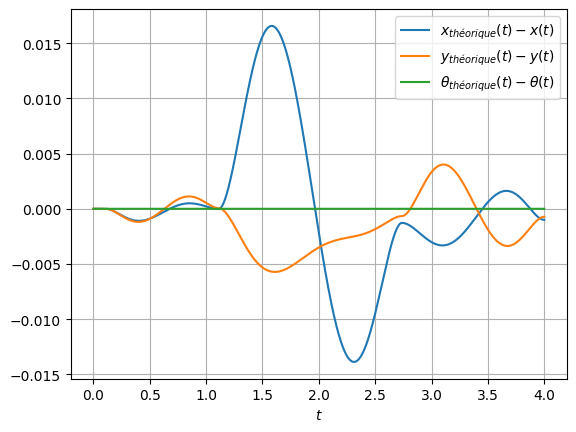

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_results(t):
    x = 2 * np.sin((np.pi/2) * t)
    y = -2 * np.cos((np.pi/2) * t) + 2
    theta = (np.pi/2) * t
    return x, y, theta

t = np.linspace(0, 4, 1500)
th_x, th_y, th_theta = theoretical_results(t)

plt.figure()
plt.plot(t, th_x - Simulation["sol"](t)[0], "-", label="$x_{théorique}(t) - x(t)$")
plt.plot(t, th_y - Simulation["sol"](t)[1], "-", label="$y_{théorique}(t) - y(t)$")
plt.plot(t, th_theta - Simulation["sol"](t)[2], "-", label="$θ_{théorique}(t) - θ(t)$")

plt.xlabel("$t$")
plt.grid()
plt.legend()
plt.show()

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

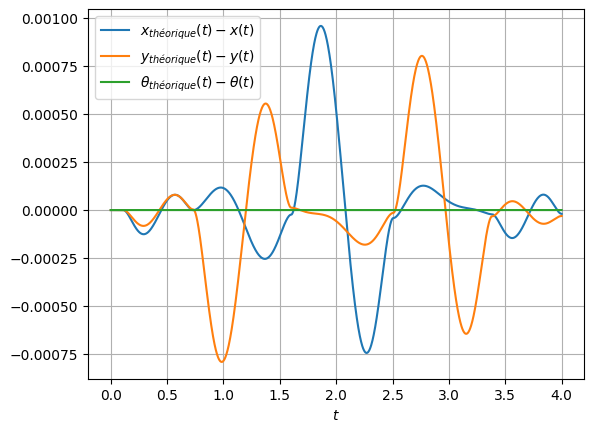

In [58]:
resultas = solve_ivp(fun=fun, t_span = (0.0, 4.0), y0 = [0.0, 0.0, 0.0], rtol=0.7*10**(-4), dense_output=True)
rt = resultas["t"]
x = resultas["y"][0]
y = resultas["y"][1]
theta = resultas["y"][2]
sol = resultas["sol"]
figure()
t = linspace(0, 4, 1500)
plot(t, th_x - sol(t)[0], "-", label="$x_{théorique}(t) - x(t)$")
plot(t, th_y - sol(t)[1], "-", label="$y_{théorique}(t) - y(t)$")
plot(t, th_theta - sol(t)[2], "-", label="$θ_{théorique}(t) - θ(t)$")
xlabel("$t$"); grid(); legend()